# ACA centroiding/ Dynamic Background/ Simulations#

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table
import astropy.units as u
from kadi import events
from mica.archive import aca_l0
import Ska.engarchive.fetch as fetch
from chandra_aca import transform
from Chandra.Time import DateTime
import Ska.Numpy
from mica import quaternion
import numpy.ma as ma
import collections
from Ska.Matplotlib import plot_cxctime
from copy import deepcopy
from importlib import reload

In [2]:
# local imports:
import sys
sys.path.append("../py")
from bgd_classes import *
import sim_aca_l0 as siml0
import centroids as cntr
import myplot as mplt

### Contents ###

1. Simulate telemetry in <code>aca_l0</code> format.
2. Construct background images using various algorithms.
3. Centroids.
4. Plotting functions.
5. Examples:
    * Simulated case with constant background, no hot pixels.
    * Simulated case with 1 hot pixel.
    * Real data (HRC, large dither amplitude of 20 arcsec).

### 1. Simulate telemetry in <code>aca_l0</code> format ###

Relevant functions are imported from <code>py/sim_aca_l0.py</code> as <code>siml0</code>.


Star is modeled as a 2D Gaussian plus constant background. It is simulated at the center of a ACA image window <code>(0 + roff, 0 + coff)</code> where the sub-pixel offsets in both row and column (<code>roff, coff</code>) are due to simulated dither (check <code>validation.ipynb</code> for details of the simulated dither).


Hot pixels are added as a dictionary <code>hot_pixels</code> with keys refering to the absolute CCD coordinates, e.g. <code>(6, 6)</code>.

### 2. Construct background images using various algorithms###

* __Patch D/ Dynamic List - Focus of this notebook.__ Detect hot pixels on-the-fly while tracking. Use n latest pixel samples.


* Relevant code is imported from <code>py/bgd_classes.py</code>.


* Implemented background classes include:

    * Current algorithm, assign average background value telemetered in <code>aca_l0</code> to each pixel, independently of its real value.
        
        * __StandardBgd__
        
    * Store real values of the sampled edge pixels, and telemetered average background value for the remaining pixels.
    
        * __DynamBgd_Median__. Median of n samples.
    
        * __DynamBgd_SigmaClip__. Sigma clipping, i.e. mean of <code>(n-2)</code> samples, after discarding max and min.

### 3. Centroids ###

Relevant functions are imported from <code>py/centroids.py</code> as <code>cntr</code>.

### 4. Plotting functions ###

Relevant functions are imported from <code>py/myplot.py</code> as <code>mplt</code>.

### 5. Examples###

* Simulate a faint 10.2 mag and a bright 8.2 mag star, with constant background, and 1 hot pixel with a set constant value.
* Compare.

In [3]:
img_size = 8 # pixels
delta_t = 4.1 # sec
integ = 1.696 # sec
nframes = 1000

In [4]:
# Define dither parameters
ampl, period = siml0.dither_acis()
phase_yaw = 0.9 # in 2 pi
phase_pitch = 0.75 # in 2 pi
phase = [phase_yaw, phase_pitch] # in 2 * np.pi
delta = 0.25 # px

In [5]:
# Average background amd kwargs for simulated aca_l0 data
bgdavg = 10. # pixel value
kwargs = {'nframes':nframes, 'delta_t':delta_t, 'integ':integ, 'bgdavg':bgdavg,
          'ampl':ampl, 'period':period, 'phase':phase, 'delta':delta}
# Example 2: with hot pixel sampled only after the first t = 500sec
# kwargs['phase'] = 0.

In [6]:
ndeque = 5 # number of vals in deque before we start to popleft()

### Example: Simulation - 1 hot pixel with constant value###

Simulate two stars, with magnitudes of 8.2 mag and 10.2 mag, and __one persistent hot pixel__, using all three background prescritions <code>(StandardBgd, DynamBgd_Median, SynamBgd_SigmaClip).</code> 

In [7]:
#hp_number = 3
hp_val = 500
#hot_pixels = simulate_hot_pixels(t_m['time'][0], hp_number, hp_val)

# Test with only one hot pixel
hot_pixels = {(6, 6):hp_val}

print(hot_pixels)

{(6, 6): 500}


In [8]:
slot = 0
mags = [10.2, 8.2] # mag

init_kwargs = [{}, {'img_size':img_size, 'bgdavg':bgdavg, 'ndeque':ndeque},
                   {'img_size':img_size, 'bgdavg':bgdavg, 'ndeque':ndeque}]

rows_all = []

for mag in mags:
    
    kwargs['mag'] = mag
    
    np.random.seed(42)
    slot_data, true_centroids = siml0.simulate_aca_l0(img_size, hot_pixels=hot_pixels, **kwargs)
    
    for i, Bgd_Class in enumerate([StandardBgd, DynamBgd_Median, DynamBgd_SigmaClip]):
        bgd_object = Bgd_Class(**init_kwargs[i]) 
        rows = cntr.centroids(slot, slot_data, img_size, bgd_object,
                              hot_pixels=None, nframes=nframes)
        for row in rows:
            row['mag'] = mag
            row['bgd_type'] = bgd_object.__class__.__name__
            row['true_row'] = true_centroids[0]
            row['true_col'] = true_centroids[1]
            y_pixels = true_centroids[0] + row['row0']
            z_pixels = true_centroids[1] + row['col0']
            true_yanzan = transform.pixels_to_yagzag(y_pixels, z_pixels)
            row['true_yan'] = true_yanzan[0]
            row['true_zan'] = true_yanzan[1]
            if isinstance(bgd_object, (DynamBgd_Median, DynamBgd_SigmaClip)):
                row['ndeque'] = ndeque
            else:
                row['ndeque'] = None

            rows_all.append(row)
        
t_hp = Table(rows_all)

Slot = 0
Slot = 0
Slot = 0
Slot = 0
Slot = 0
Slot = 0


In [9]:
print(t_hp.colnames)
print()
print(t_hp['bgd_type', 'mag', 'ndeque'])

['bgd_type', 'bgdimg', 'col', 'col0', 'deque_dict', 'imgraw', 'mag', 'ndeque', 'row', 'row0', 'slot', 'time', 'true_col', 'true_row', 'true_yan', 'true_zan', 'yan', 'zan']

     bgd_type      mag  ndeque
------------------ ---- ------
       StandardBgd 10.2   None
   DynamBgd_Median 10.2      5
DynamBgd_SigmaClip 10.2      5
       StandardBgd  8.2   None
   DynamBgd_Median  8.2      5
DynamBgd_SigmaClip  8.2      5


__Plot derived bgd images__

* <span style="color:blue">Blue patch</span> - region eventually covered due to the dither
* <span style="color:red">Red patch</span> - 8x8 pixel region corresponding to the current frame

Format of the titles is 'time: imgrow0, imgcol0'
Plot bgd images from 0 to 10
Method: DynamBgd_Median, ndeque = 5


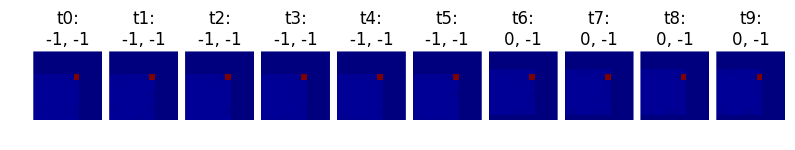

In [30]:
mplt.plot_bgd_images(t_hp, slot=0, n_start=0, n_stop=10, img_size=img_size, method='DynamBgd_Median')

* <span style="color:blue">Blue patch</span> - region eventually covered due to the dither
* <span style="color:red">Red patch</span> - region sampled at time t (the sampled region increases with t)

Format of the titles is 'time: imgrow0, imgcol0'
Plot frames from 0 to 10
Method: DynamBgd_Median, ndeque = 5


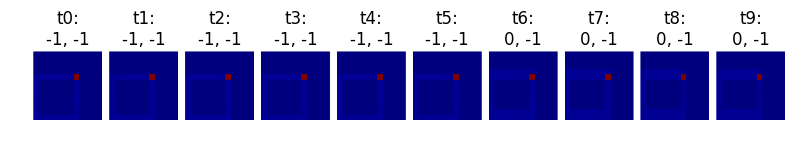

In [31]:
mplt.plot_bgd_patches(t_hp, slot=0, n_start=0, n_stop=10, img_size=img_size,
                      method='DynamBgd_Median')

* <span style="color:blue">Blue patch</span> - region eventually covered due to the dither
* <span style="color:red">Red patch</span> - region sampled at time t (the sampled region increases with t)

Format of the titles is 'time: imgrow0, imgcol0'
Plot frames from 990 to 1000
Method: DynamBgd_Median, ndeque = 5


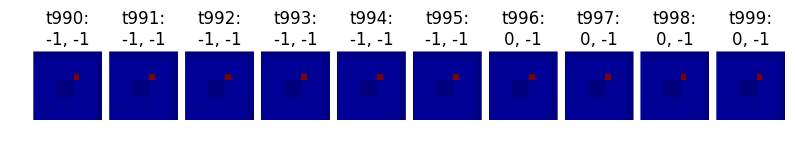

In [32]:
n_start = nframes - 10
mplt.plot_bgd_patches(t_hp, slot=0, n_start=n_start, n_stop=nframes, img_size=img_size,
                      method='DynamBgd_Median')

__Plot the computed and 'true' centroids (row number and yan coordinates)__

In [29]:
reload(mplt)

<module 'myplot' from '../py/myplot.py'>

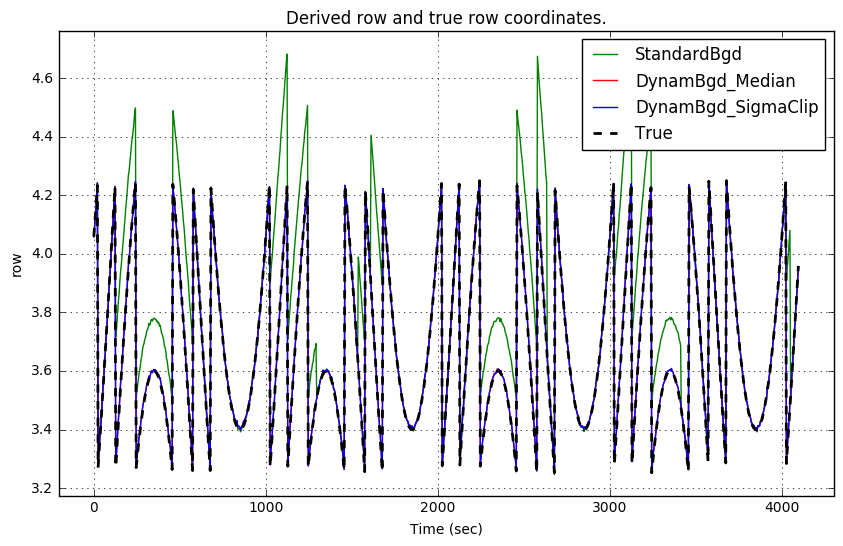

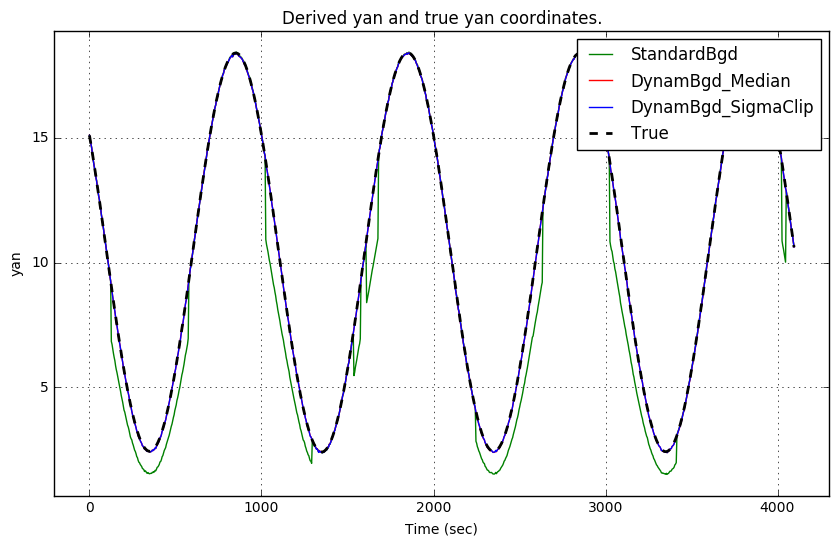

In [19]:
mplt.plot_coords(slot, t_hp, 'row') # computed 'row' coordinate (between 0 and 8)
mplt.plot_coords(slot, t_hp, 'yan') # computed 'yan' coordinate

__Plot the difference between the computed and 'true' coordinates__

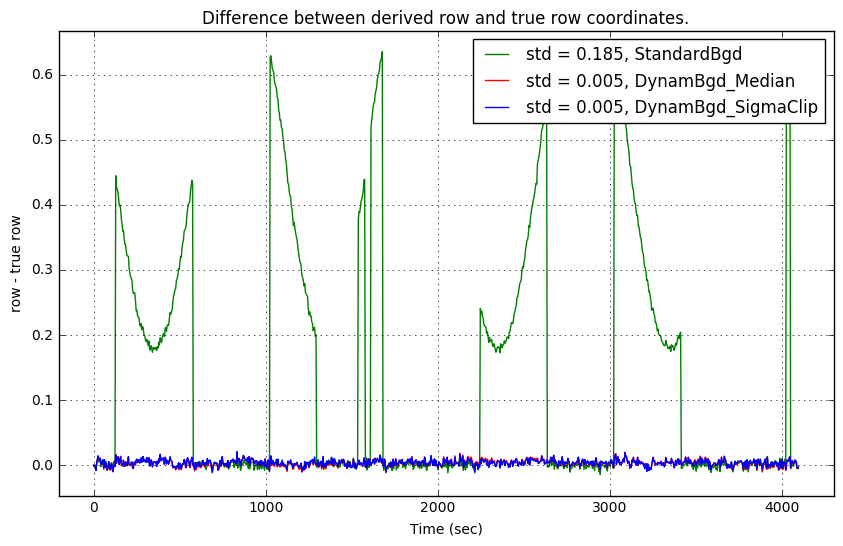

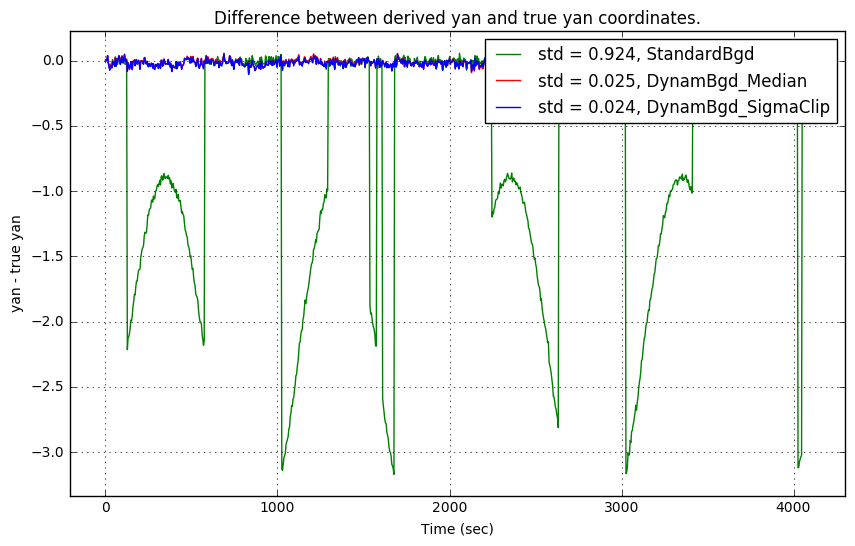

In [20]:
mplt.plot_coords_excess(slot, t_hp, 'row')
mplt.plot_coords_excess(slot, t_hp, 'yan')

__Plot residuals__

Bright - Faint star


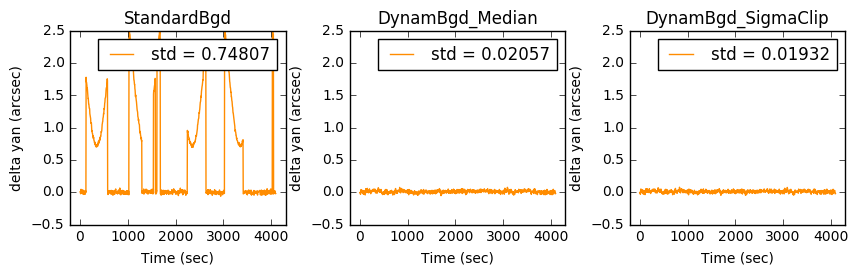

In [40]:
faint = t_hp['mag'] == 10.2
bright = t_hp['mag'] == 8.2

key = 'yan'

fig = plt.figure(figsize=(10, 2.5))

ylim = (-0.5, 2.5)

methods = ['StandardBgd', 'DynamBgd_Median', 'DynamBgd_SigmaClip']

for i, method in enumerate(methods):
    plt.subplot(1, 3, i + 1)
    d_ang = t_hp[bright][key][i] - t_hp[faint][key][i]
    plt.plot(t_hp['time'][0], d_ang, color='Darkorange',
             label='std = {:.5f}'.format(np.std(d_ang - np.median(d_ang))))
    plt.title(method)    
    plt.xlabel('Time (sec)')
    plt.ylabel('delta {} (arcsec)'.format(key))
    plt.legend()
    plt.ylim(ylim)
    plt.margins(0.05)
    
plt.subplots_adjust(wspace=0.3)
print("Bright - Faint star")

### Example: Simulation - 1 hot pixel with flickering value###

Simulate two stars, with magnitudes of 8.2 mag and 10.2 mag, and __one hot flickering pixel__, using all three background prescritions <code>(StandardBgd, DynamBgd_Median, SynamBgd_SigmaClip).</code> 